# RSA Integration Kit
This document demonstrates encryption and decryption of a file using a dedicated RSA accelerator for the PYNQ platform. It is developed as a part of the term project given in the course TFE4141 Design of Digital Systems 1 at the Department of Electronic Systems at the Norwegian University of Science and Technology.


# Digital design flow

Before starting the work on designing a digital circuit, a reminder of the digital hardware design flow is in place. 

1) Capture the requirements

2) Create a high level functional model. This model must produce the correct result, but is written at a very high abstraction level.

3) Design exploration. Use models at different abstraction levels. Try out different algorithms. What asymptotic complexity do they have? Is the problem parallelizable in any way? Can you use multiple cores and/or pipeline the design to increase the throughput?

4) Propose a microarchitecture at the register transfer level. The block diagram should be detailed enough that it identifies registers, muxes, adders and similar units. 

5) Estimate the performance and the area of your design. Estimate the clock frequency as well as the throughput.

6) Write the RTL kode for your design.

7) Verify functional correctness of the design. Use e.g. constrained random self checking testbenches or formal verification. 

8) Verify the performance of the design. Create special test in order to check that the performance is as expected.

9) Prototype the design e.g. on an FPGA. Do system testing.


# Constants
The following constants must be set to the appropriate values before attempting any encrypt/decrypt operations.

In [61]:
# ------------------------------------------------------------------------------
# Set the blocksize
# ------------------------------------------------------------------------------
C_BLOCKSIZE_IN_BITS         = 256
C_BLOCKSIZE_IN_32_BIT_WORDS = 8
C_BLOCKSIZE_IN_BYTES        = 32

# ------------------------------------------------------------------------------
# It is possible to choose between two different algorithms: 
#   XOR: This is the algorithm you can use for testing the system before you
#        have integrated the RSA hardware accelerator.
#        Computes: C=M xor n, M=C xor n
#
#   RSA: This is the algorithm you must enable when you have integrated the
#        RSA hardware accelerator.
#        Computes: C=M**e mod n, M=C**d mod n
# ------------------------------------------------------------------------------
C_ENCR_ALGORITHM_XOR = 0
C_ENCR_ALGORITHM_RSA = 1
C_ENCR_ALGORITHM = C_ENCR_ALGORITHM_RSA

# ------------------------------------------------------------------------------
# Import python libraries
# ------------------------------------------------------------------------------
import numpy as np
import time

# Utility functions

Messages will be read and written to files and sent in and out of the Pynq platform. In the following section a few utility functions for moving and converting data has been implemented.

In [62]:
# ------------------------------------------------------------------------------
# Function for converting an array of messages to a numpy array of 32-bit words
# ------------------------------------------------------------------------------
def msg2word(msg_array):
  word_array_array = []
  # Produce one word array per message
  for msg in msg_array: 
    msg_in_bytes = msg.to_bytes(C_BLOCKSIZE_IN_BYTES,byteorder='little')
    word_array_array.append(np.frombuffer(msg_in_bytes, dtype=np.uint32))
  
  # Concatentate the small word arrays into one large
  word_array = np.concatenate(word_array_array)    
  
  # Return the array of words
  return word_array

# ------------------------------------------------------------------------------
# Function for converting an numpy array of 32-bit words into messages
# ------------------------------------------------------------------------------
def word2msg(word_array):
  msg_array = []

  # Check that the message array size is a multiplum of 8 32 bit words
  word_array_length = len(word_array)
  assert word_array_length%C_BLOCKSIZE_IN_32_BIT_WORDS == 0, "The file size must be aligned to the block size" 
  message_count = int(word_array_length/C_BLOCKSIZE_IN_32_BIT_WORDS)

  # Loop over all messages
  for i in range(message_count):
    
    # Concatinate 32-bit words to a 256-bit message
    M = 0
    for j in range(C_BLOCKSIZE_IN_32_BIT_WORDS):
      M += (int(word_array[i*C_BLOCKSIZE_IN_32_BIT_WORDS+j]) << (j*32))
    
    # Append the message
    msg_array.append(M)
    
  # Return the message array
  return msg_array

# ------------------------------------------------------------------------------
# Function for testing msg2word word2msg conversion
# ------------------------------------------------------------------------------
def test_msg2msg():

  ma_in = [0x0000000011111111222222223333333344444444555555556666666677777777,
           0x8888888899999999aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeeffffffff]
  wa = msg2word(ma_in)
  ma_out = word2msg(wa)
  if(ma_in==ma_out):
    print("test_msg2msg: PASSED")
  else:
    print("test_msg2msg: FAILED")
    
# ------------------------------------------------------------------------------
# Run a test of the utility functions
# ------------------------------------------------------------------------------
test_msg2msg()    

test_msg2msg: PASSED


# Message to encrypt/decrypt
The messages that will be encrypted/decrypted must all be downloaded from Blackboard and stored on the pynq platform. Copy the folder named "crypto" from Blackboard and paste it into the following location on the Pynq platform prior to running this jupyter notebook: 

/home/xilinx/pynq

The plaintex messages satisfy the following properties: 
* Property1: The size of the file must be a multiple of the block size, i.e. the filesize in bytes must be dividable by 32.
* Property2: C = M**e mod n, for 0 <= M < n. 

The second property has been satisfied through the following: 
* The files have been generated in such a way that they contain only ASCII characters with a byte value equal or lower than 127. The most significant bit in every byte is therefore 0, and thus it is also guaranteed that the MSB of any 256 bit blocks will be 0. 
* n is selected in such a way that the MSB of n is always 1.  

In [63]:
from pathlib import Path

# Two sets of testcases exists. One set used when the RSA algorithm is
# selected and another set for the XOR algorithm.
if(C_ENCR_ALGORITHM == C_ENCR_ALGORITHM_RSA):
  inp_msgdir = """/home/xilinx/pynq/crypto/rsa/inp_messages/"""
  otp_hw_msgdir = """/home/xilinx/pynq/crypto/rsa/otp_hw_messages/"""
  otp_sw_msgdir = """/home/xilinx/pynq/crypto/rsa/otp_sw_messages/"""    
else:
  inp_msgdir = """/home/xilinx/pynq/crypto/xor/inp_messages/"""
  otp_hw_msgdir = """/home/xilinx/pynq/crypto/xor/otp_hw_messages/"""
  otp_sw_msgdir = """/home/xilinx/pynq/crypto/xor/otp_sw_messages/"""    

# Name of the files to encrypt and decrypt
inp_files = ["pt0_in.txt", "pt1_in.txt", "pt2_in.txt", "ct3_in.txt", "ct4_in.txt", "ct5_in.txt"]
otp_files = ["ct0_out.txt", "ct1_out.txt", "ct2_out.txt", "pt3_out.txt", "pt4_out.txt", "pt5_out.txt"]
crypt_dir = ["ENCR", "ENCR", "ENCR", "DECR", "DECR", "DECR"]

# Testcase count
num_testcases = len(inp_files)

# Function for retrieving filenames for the different testcases
def get_testcase(testcase_sel):
  inp_file    = Path(inp_msgdir    + inp_files[testcase_sel])
  otp_hw_file = Path(otp_hw_msgdir + otp_files[testcase_sel])
  otp_sw_file = Path(otp_sw_msgdir + otp_files[testcase_sel])
  direction   = crypt_dir[testcase_sel]
  return direction, inp_file, otp_hw_file, otp_sw_file

# Check whether or not the files exist
for i in range(num_testcases):
  direction, inp_file, otp_hw_file, otp_sw_file = get_testcase(i)
  if not(inp_file.is_file()):
    print("File %s is missing. Download the file from Blackboard!" % str(inp_file))


# Keys and key generation

Pseudocode for RSA key generation is available here: https://repl.it/@Snesemann/RSAKeyGenAndEncrypt

When encrypting and decrypting the files in this script, the following keys will be used:

<pre>
n: 99925173 ad656867 15385ea8 00cd2812 0288fc70 a9bc98dd 4c90d676 f8ff768d
e: 00000000 00000000 00000000 00000000 00000000 00000000 00000000 00010001
d: 0cea1651 ef44be1f 1f1476b7 539bed10 d73e3aac 782bd999 9a1e5a79 0932bfe9
</pre>

In [64]:
key_n = 0x99925173ad65686715385ea800cd28120288fc70a9bc98dd4c90d676f8ff768d
key_e = 0x0000000000000000000000000000000000000000000000000000000000010001
key_d = 0x0cea1651ef44be1f1f1476b7539bed10d73e3aac782bd9999a1e5a790932bfe9
R2N   = 0x07baae31ed8a283c0e1c033c45e3b140d1f769e7ece01e8e0a1247934b0b0b4b
M_inv = 0x3
# R2N =   0x0076843924743289472984837140321784032748743021472389

# Software implementation of the RSA encryption algorithm
When designing digital circuits it is common to create a high level functional model. The following model is written at an extremely high level. It will produce correct results that can be used when generating test vectors for verification environments, but it does not provide any other value. It is expected that designers create more detailed models before attempting to write any RTL code. 


In [65]:
# ------------------------------------------------------------------------------
# Function for encrypting messages
# key_e  : 256 bit integer representing the key e
# key_n  : 256 bit integer representing the key n
# M_array: Array of 256-bit messages.
# ------------------------------------------------------------------------------
def sw_encrypt(key_e, key_n, M_array):
  
  # Initialize the array where we will store the ciphertext
  C_array = []

  # Start the timer
  start_time = time.time()

  # Loop over all messages
  for M in M_array:
    # Encrypt the message by computing C = M**key_e mod key_n
    # The result is a 256-bit ciphertext  
    if(C_ENCR_ALGORITHM == C_ENCR_ALGORITHM_RSA):    
      C = pow(M, key_e, key_n)
    
    # Encrypt the message by computing C = M xor key_n    
    else:
      C = M ^ key_n
        
    C_array.append(C)

  # Stop the timer
  stop_time = time.time()
  sw_exec_time = stop_time-start_time
        
  return C_array, sw_exec_time

# ------------------------------------------------------------------------------
# Function for decrypting messages
# key_d  : 256 bit integer representing the key e
# key_n  : 256 bit integer representing the key n
# C_array: Array of 256-bit messages.
# ------------------------------------------------------------------------------
def sw_decrypt(key_d, key_n, C_array):
  # Decryption is the same function as encryption, just with different keys
  return sw_encrypt(key_d, key_n, C_array)

# ------------------------------------------------------------------------------
# Function for testing encryption and decryption in software
# ------------------------------------------------------------------------------
def test_sw_encryptdecrypt(key_e, key_d, key_n):
  M_arr_in = [0xa232020202020202020202020202f5f5f2020205f5f5c7c2f20202020205c7c,
              0x8888888899999999aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeeffffffff]
  C_arr, sw_encr_time = sw_encrypt(key_e, key_n, M_arr_in)
  M_arr_out, sw_decr_time = sw_decrypt(key_d, key_n, C_arr)
  print(f"Encrypted message:{hex(C_arr[0])}")
  print(f"Decrypted message:{hex(M_arr_out[0])}")
  if(M_arr_in == M_arr_out):
    print("test_hw_encryptdecrypt: PASSED, encr_time: %f, decr_time: %f" % (sw_encr_time, sw_decr_time))    
  else:
    print("test_sw_encryptdecrypt: FAILED")   
  
# ------------------------------------------------------------------------------
# Test that the software implementation of encryption and decryption works
# ------------------------------------------------------------------------------
test_sw_encryptdecrypt(key_e, key_d, key_n)
  

Encrypted message:0x6772dd02155f2ffe66ce467c3834b7e9982128043b1bf818ac87a5fbc15f4b30
Decrypted message:0xa232020202020202020202020202f5f5f2020205f5f5c7c2f20202020205c7c
test_hw_encryptdecrypt: PASSED, encr_time: 0.000493, decr_time: 0.009033


# RSA encryption using an hardware accelerator

In the following code blocks, we test out the hardware RSA accelerator and measure it's performance.

In [66]:
# ------------------------------------------------------------------------------
# Loading drivers for the direct memory access block (DMA) that is responsible
# for reading the messages from memory and pushing them into the RSA design.
# ------------------------------------------------------------------------------
from pynq import Overlay
import pynq.lib.dma

# Load the overlay
overlay = Overlay('/home/xilinx/pynq/overlays/rsa_soc/rsa_soc.bit')

# Load the RSA DMA
dma = overlay.rsa.rsa_dma

# Load the MMIO driver for the RSA accelerator
rsammio = overlay.rsa.rsa_acc.mmio


In [67]:
# ------------------------------------------------------------------------------
# Function for writing C_BLOCKSIZE_IN_32_BIT_WORDS consequtive registers
# ------------------------------------------------------------------------------
def write_blockreg(address, block):
  reg_data = msg2word([block])
  addr = address
  # Each register contains 4 bytes. The registers are byte addressed.
  for data in reg_data:
    rsammio.write(addr, int(data))
    addr += 4

# ------------------------------------------------------------------------------
# Function for reading C_BLOCKSIZE_IN_32_BIT_WORDS consequtive registers
# ------------------------------------------------------------------------------
def read_blockreg(address):
  addr = address
  reg_arr = []
  for i in range(C_BLOCKSIZE_IN_32_BIT_WORDS):
    reg_arr.append(rsammio.read(addr))
    addr += 4
  reg_data = word2msg(reg_arr)[0]
  return reg_data
    
# ------------------------------------------------------------------------------
# Function for writing keys to the RSA accelerator
# ------------------------------------------------------------------------------
def write_keys(key_n, key_e_or_d, R2N, M_inv):
  # Store N and E
  write_blockreg(0x00, key_n)
  write_blockreg(0x20, key_e_or_d)
  write_blockreg(0x40, R2N)
  write_blockreg(0x60, M_inv)

# ------------------------------------------------------------------------------
# Function for reading keys from the RSA accelerator
# ------------------------------------------------------------------------------
def read_keys():
  # Read N, E
  n = read_blockreg(0x00)
  e_or_d = read_blockreg(0x20)
  R2N = read_blockreg(0x40)
  M_inv = read_blockreg(0x60)
  return n, e_or_d, R2N, M_inv

# ------------------------------------------------------------------------------
# Write the keys and read them back. Compare the result
# ------------------------------------------------------------------------------
def test_write_read_keys():
  write_keys(key_n, key_e, R2N, M_inv)
  n, e, R2N_test, M_test = read_keys()
  if((key_n == n) and (key_e == e) and (R2N_test == R2N) and (M_test == M_inv)):
    print("test_write_read_keys: PASSED")
  else:
    print("test_write_read_keys: FAILED")

# ------------------------------------------------------------------------------
# Test writing keys to the accelerator and reading back the keys
# ------------------------------------------------------------------------------
test_write_read_keys()

test_write_read_keys: PASSED


In [68]:
from pynq import Xlnk
import random
import numpy as np

# ------------------------------------------------------------------------------
# Function that computes C = M**e mode n 
# key_e  : 256 bit integer representing the key e
# key_n  : 256 bit integer representing the key n
# M_array: Array 256-bit blocks.
# ------------------------------------------------------------------------------
def hw_encrypt(key_e, key_n, M_array, R2N, M_inv):

  # Write the keys
  write_keys(key_n, key_e, R2N, M_inv)
            
  # Allocate buffers for the input and output signals. 
  M_word_array = msg2word(M_array)
  xlnk = Xlnk()
  buffer_size_in_words = len(M_word_array)    
  print("Buffer size:", buffer_size_in_words)

  # The size of the files must be aligned to the block size of 256 bit = 8*32 bit words
  assert buffer_size_in_words%C_BLOCKSIZE_IN_32_BIT_WORDS == 0, "The file size must be aligned to the block size of 256 bit" 
    
  in_buffer  = xlnk.cma_array(shape=(buffer_size_in_words,), dtype=np.uint32)
  out_buffer = xlnk.cma_array(shape=(buffer_size_in_words,), dtype=np.uint32)

  # Copy the samples to the in_buffer
  np.copyto(in_buffer, M_word_array)

  # Trigger the DMA transfer and wait for the result
  # Waiting for completeness is done trough polling of registers. Measurements of
  # consumed time will be more accurate with the use of interrupts.
  start_time = time.time()
  dma.sendchannel.transfer(in_buffer)
  dma.recvchannel.transfer(out_buffer)
  #print("DMA.sendchannel complete")
  #dma.sendchannel.wait()
  #print(f"Status:{hex(read_blockreg(0x80))}")
    
  #print("DMA.recvchannel complete") 
  # Should be sufficient to wait for the recieve channel to complete. This 
  # will reduce some of the polling overhead when running tests.
  dma.recvchannel.wait()
  stop_time = time.time()
  hw_exec_time = stop_time-start_time

  # Copy the result  
  C_word_array = out_buffer.copy()
  C_array = word2msg(C_word_array)
  
  # Free the buffers
  in_buffer.close()
  out_buffer.close()

  # Return the result
  return C_array, hw_exec_time

# ------------------------------------------------------------------------------
# Function that computes M = C**d mode n
#
# Encryption and decryption is the same operation. Thus the hw_decrypt function
# is redundant.
# ------------------------------------------------------------------------------
def hw_decrypt(key_d, key_n, C_array, R2N, M_inv):
  return hw_encrypt(key_d, key_n, C_array, R2N, M_inv)

# ------------------------------------------------------------------------------
# Function for testing encryption and decryption in hardware
# ------------------------------------------------------------------------------
def test_hw_encryptdecrypt(key_e, key_d, key_n, R2N, M_inv):
  M_arr_in = [0x8888888899999999aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeeffffffff]
  C_arr, hw_encr_time = hw_encrypt(key_e, key_n, M_arr_in,R2N, M_inv)
  M_arr_out, hw_decr_time = hw_decrypt(key_d, key_n, C_arr, R2N, M_inv)
  
  if(M_arr_in == M_arr_out):
    print("test_hw_encryptdecrypt: PASSED, encr_time: %f, decr_time: %f" % (hw_encr_time, hw_decr_time))
    #print("M_arr_in: ",  hex(M_arr_in[0]))   
    #print("C_arr: ",     hex(C_arr[0]))             
    #print("M_arr_out: ", hex(M_arr_out[0])) 
  else:
    print("test_hw_encryptdecrypt: FAILED")
    #print("M_arr_in: ",  hex(M_arr_in[0]))   
    #print("C_arr: ",     hex(C_arr[0]))             
    #print("M_arr_out: ", hex(M_arr_out[0]))                       
  
# ------------------------------------------------------------------------------
# Test that the hardware implementation of encryption and decryption works
# ------------------------------------------------------------------------------
test_hw_encryptdecrypt(key_e, key_d, key_n,R2N, M_inv)
#0x998166ea34647976371a7c8a33fe1b2146ccb834fce9cd882af6b0108f8801fa -cipher
#0x99925173ad65686715385ea800cd28120288fc70a9bc98dd4c90d676f8ff768d - n-key
#0x99925173ad65686715385ea800cd28120289ed618be9cd882af6b0108f8801fa
#0x99925173ad647976371a7c8a33fe1b2146ccb834fce9cd882af6b0108f8801fa
#0x01111 1225 5555 5666 6666 6777 7777 7
#0x925173ad65686715385ea800cd28120289ed618b

Buffer size: 8
Buffer size: 8
test_hw_encryptdecrypt: PASSED, encr_time: 0.000523, decr_time: 0.000904


# Encrypt and decrypt long messages in hardware and software

Results from encrypting and decrypting files in hardware and software.

In [69]:
# ------------------------------------------------------------------------------
# Loop over all files encrypt/decrypt and store the results.
# ------------------------------------------------------------------------------
hw_runtime = []
sw_runtime = []

for i in range(num_testcases):
  direction, inp_file, otp_hw_file, otp_sw_file = get_testcase(i)
  print("*"*80)
  print("CRYPT DIR       : ", direction)
  print("INPUT FILE      : ", inp_file)
  print("OUTPUT FILE (HW): ", otp_hw_file)
  print("OUTPUT FILE (SW): ", otp_sw_file)
  if(C_ENCR_ALGORITHM == C_ENCR_ALGORITHM_RSA):
    print("ENCR ALGORITHM  : RSA")
  else: 
    print("ENCR ALGORITHM  : XOR")    
  print("*"*80)
  input_msg_data                   = word2msg(np.fromfile(str(inp_file),dtype=np.uint32))
  if(direction == "ENCR"):
    output_msg_hw_data, hw_exec_time = hw_encrypt(key_e, key_n, input_msg_data, R2N, M_inv)
    hw_runtime.append(hw_exec_time)
    output_msg_sw_data, sw_exec_time = sw_encrypt(key_e, key_n, input_msg_data)
    sw_runtime.append(sw_exec_time)
    #print(f"Hardware Encrypted:{hex(output_msg_hw_data[i])}")
    #print(f"Software Encrypted:{hex(output_msg_sw_data[i])}")
    print("HW RUNTIME: ", hw_exec_time)    
    print("SW RUNTIME: ", sw_exec_time)    
  elif(direction == "DECR"):
    output_msg_hw_data, hw_exec_time = hw_decrypt(key_d, key_n, input_msg_data, R2N, M_inv)
    hw_runtime.append(hw_exec_time)
    output_msg_sw_data, sw_exec_time = sw_decrypt(key_d, key_n, input_msg_data)
    sw_runtime.append(sw_exec_time)
    #print(hex(output_msg_hw_data[i]))
    #print(hex(output_msg_sw_data[i]))
    print("HW RUNTIME: ", hw_exec_time)    
    print("SW RUNTIME: ", sw_exec_time)    
    
  # Compare results
  if(output_msg_sw_data == output_msg_hw_data):
    print("HW and SW produced the same result: TEST PASSED")
  else:
    print("HW and SW output did not match: TEST FAILED")


        
  # Write the results to file
  msg2word(output_msg_hw_data).tofile(str(otp_hw_file))
  msg2word(output_msg_sw_data).tofile(str(otp_sw_file))    
    
    

********************************************************************************
CRYPT DIR       :  ENCR
INPUT FILE      :  /home/xilinx/pynq/crypto/rsa/inp_messages/pt0_in.txt
OUTPUT FILE (HW):  /home/xilinx/pynq/crypto/rsa/otp_hw_messages/ct0_out.txt
OUTPUT FILE (SW):  /home/xilinx/pynq/crypto/rsa/otp_sw_messages/ct0_out.txt
ENCR ALGORITHM  : RSA
********************************************************************************
Buffer size: 504
HW RUNTIME:  0.0040149688720703125
SW RUNTIME:  0.016221046447753906
HW and SW produced the same result: TEST PASSED
********************************************************************************
CRYPT DIR       :  ENCR
INPUT FILE      :  /home/xilinx/pynq/crypto/rsa/inp_messages/pt1_in.txt
OUTPUT FILE (HW):  /home/xilinx/pynq/crypto/rsa/otp_hw_messages/ct1_out.txt
OUTPUT FILE (SW):  /home/xilinx/pynq/crypto/rsa/otp_sw_messages/ct1_out.txt
ENCR ALGORITHM  : RSA
********************************************************************************
Bu

# Plot results


<IPython.core.display.Javascript object>


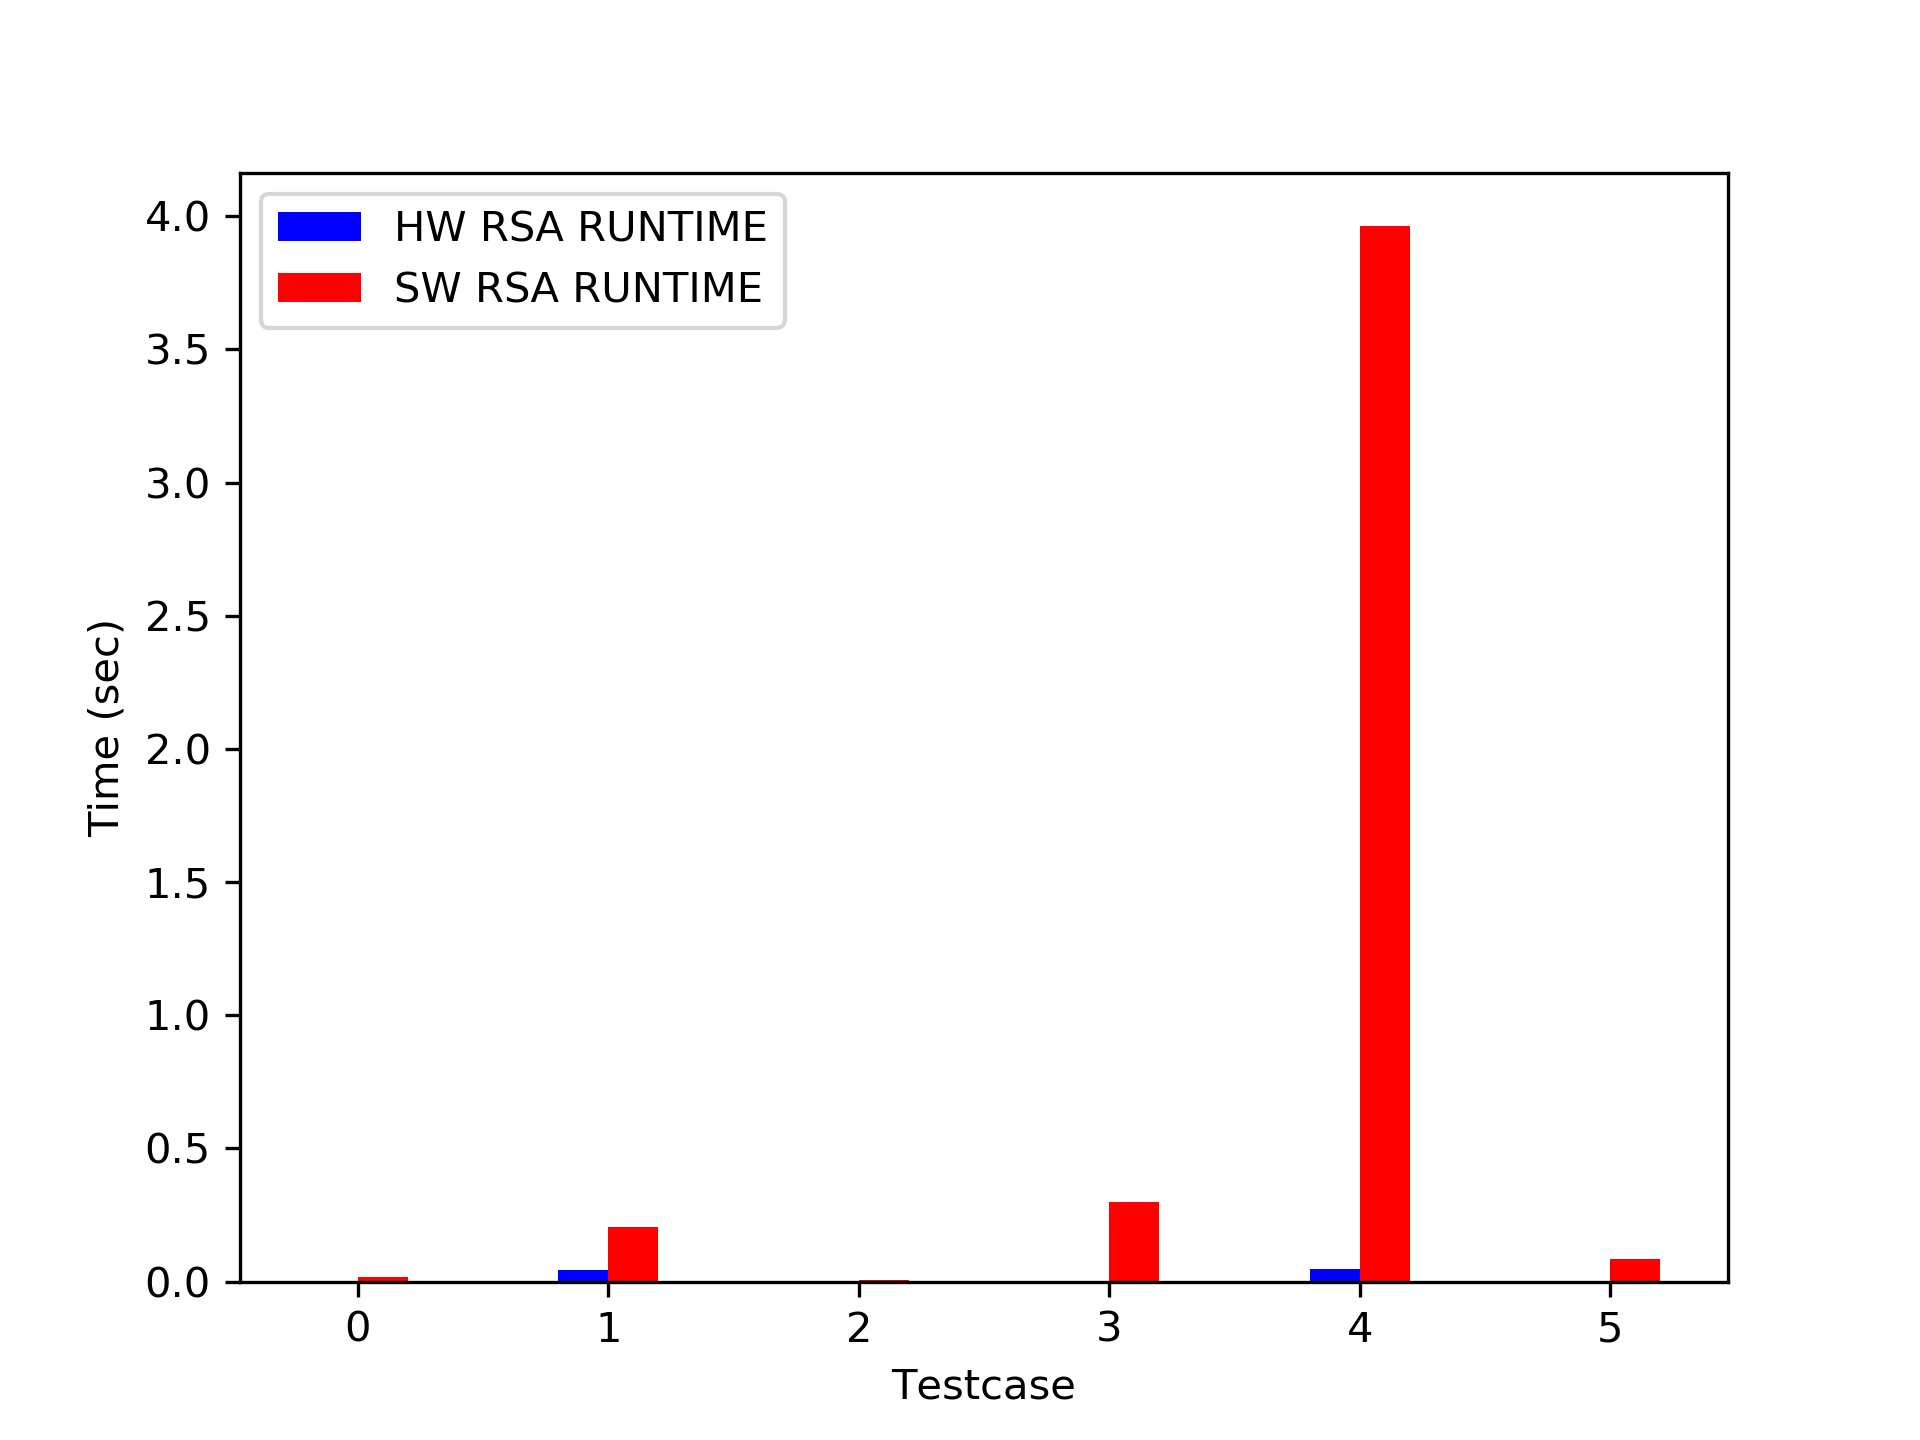

In [70]:
%matplotlib notebook
import matplotlib.pyplot as plt

if(C_ENCR_ALGORITHM == C_ENCR_ALGORITHM_RSA):
  ALGORITHM = "RSA"
else: 
  ALGORITHM = "XOR"
    
runtime_plot = plt.figure()
ax = plt.subplot(111)
hw_testcases = [i-0.1 for i in range (len(inp_files))]
sw_testcases = [i+0.1 for i in range (len(inp_files))]
plt.ylabel('Time (sec)')
plt.xlabel('Testcase')
ax.bar(hw_testcases, hw_runtime,width=0.2,color='b',align='center', label='HW %s RUNTIME' % ALGORITHM)
ax.bar(sw_testcases, sw_runtime,width=0.2,color='r',align='center', label='SW %s RUNTIME' % ALGORITHM)
plt.legend()

# Discussion of results

## Discussion of XOR results
The overhead for running the HW encryption is relatively large. For small tests, such as 0,2,3 and 5, the performance of the HW solution is low compared to the SW solution. For the HW polling of registers is used for detecting when the encryption/decryption is completed. An improvement that will reduce the overhead is to implement support for interrupts.

Tests 1 and 4 are longer and here the HW is clearly faster than the SW solution since the overhead is no longer dominating the runtime of the HW.

## Discussion of RSA results
RSA is a much more demainding algorithm and should run slowly in software for most tests compared to the HW. 